# darts 时序建模入门

darts是一个强大而易用的Python时间序列建模工具包。

DARTS(Data-driven ARchimedean Transform for Seriation)

主要支持以下任务: 

* 时间序列预测 (包含 ARIMA, LightGBM模型, TCN, N-BEATS, TFT, DLinear, TiDE等等)

* 时序异常检测 (包括 分位数检测 等等)

* 时间序列滤波 (包括 卡尔曼滤波，高斯过程滤波)

项目 github地址： https://github.com/unit8co/darts

examples范例文档： https://unit8co.github.io/darts/examples.html

本文演示使用darts构建N-BEATS模型对 牛奶月销量数据进行预测~

In [ ]:
!pip install darts

## 一,  准备数据

首先，你需要准备时间序列数据。 如果数据有缺失，需要进行数据填充。

这里示范的是一个每月牛奶销量数据集。


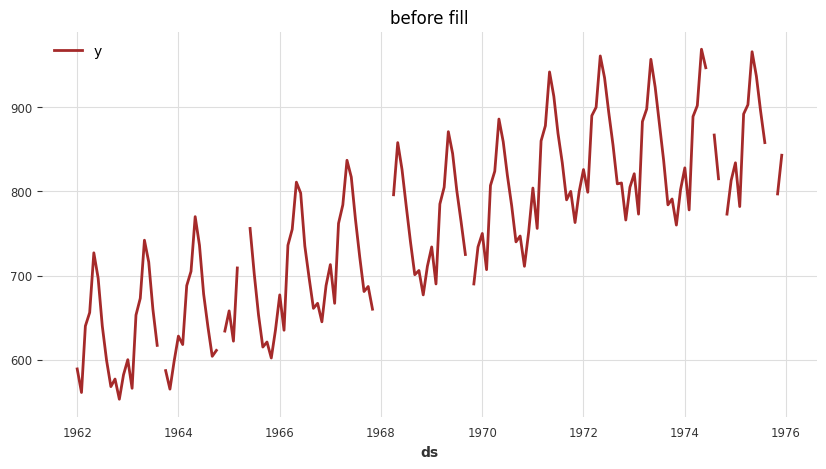

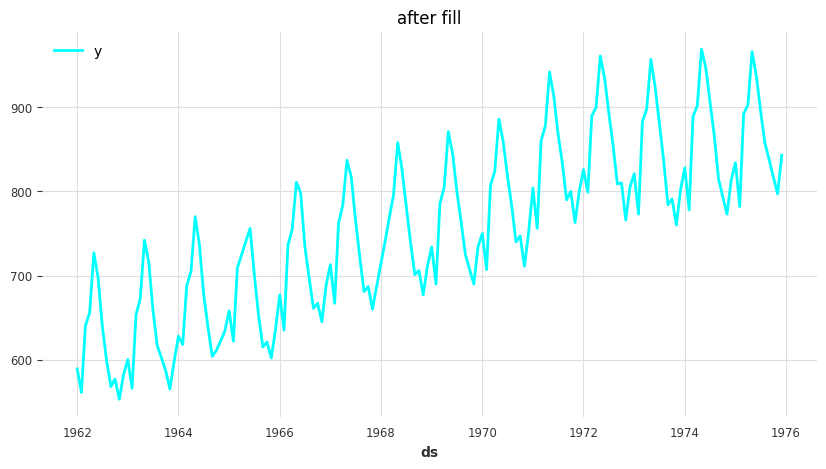

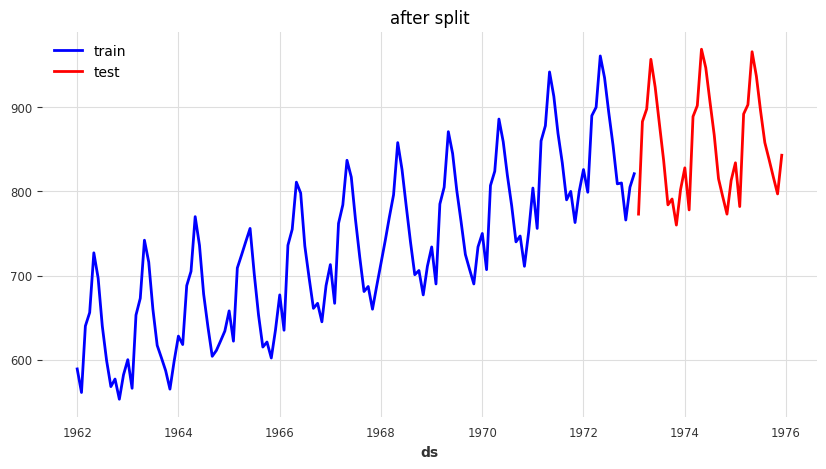

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt

import darts
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.dataprocessing.transformers import Scaler 


from darts.datasets import  MonthlyMilkIncompleteDataset
ds = MonthlyMilkIncompleteDataset().load() 
ds.to_csv('month_milk.csv')

# 1，读取数据集
df = pd.read_csv('month_milk.csv')
df.columns = ['ds','y']
df = df.sort_values(by='ds')
#df['y'] = df['y'].interpolate(method='linear')


# 2，填充数据集
ts_raw = TimeSeries.from_dataframe(df,time_col='ds',value_cols=['y'])
#df = ts_raw.pd_dataframe() #timeseries转成dataframe
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))
ts_raw.plot(color='brown',ax = ax1)
ax1.set_title('before fill')

#from darts.utils.missing_values import fill_missing_values
#ts = fill_missing_values(ts_raw)

filler = MissingValuesFiller()
ts = filler.transform(ts_raw)

fig, ax2 = plt.subplots(1, 1, figsize=(10,5))
ts.plot(color='cyan', ax = ax2)
ax2.set_title('after fill')

# 3，分割数据集
ts_train, ts_test= ts.split_after(pd.Timestamp("1973-01-01")) 
fig, ax3 = plt.subplots(1,1,figsize=(10,5))
ts_train.plot(color='blue',label='train',ax=ax3)
ts_test.plot(color='red',label='test',ax=ax3)
ax3.set_title('after split');




# 4，缩放数据集
scaler = Scaler()
ts_train_scaled = scaler.fit_transform(ts_train)
ts_test_scaled = scaler.transform(ts_test)
ts_scaled = scaler.transform(ts)


## 二， 定义模型

接下来，定义一个时间序列模型。Darts支持多种模型。

包括统计模型(ARIMA, FFT, ExponentialSmoothing等)

机器学习模型(Prophet,LightGBM等)

神经网络模型(RNN类型，Transformer类型，CNN类型，MLP类型)。

此处我们使用 NBeats模型。



In [ ]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import wandb
wandb.login()

In [ ]:
from darts.models import NBEATSModel 
import pytorch_lightning as pl 
from darts.utils.callbacks import TFMProgressBar
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project='MILK')
progress_bar = TFMProgressBar(enable_train_bar_only=True)
early_stopper = pl.callbacks.EarlyStopping(monitor="val_loss",patience=10,
        min_delta=1e-5,mode="min")
pl_trainer_kwargs = dict(max_epochs=100, 
     accelerator='cpu',
     callbacks = [progress_bar,early_stopper],
     logger = wandb_logger
) 

settings = dict(
    input_chunk_length=10,
    output_chunk_length=3,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    save_checkpoints=True,
    
    batch_size=800,
    random_state=42,
    model_name='nbeats',
    force_reset=True
)

settings['pl_trainer_kwargs'] = pl_trainer_kwargs

model = NBEATSModel(**settings)

## 三，训练模型

In [ ]:
model.fit(series = ts_train_scaled, val_series= ts_train_scaled)

In [50]:
model = model.load_from_checkpoint(model_name=model.model_name,best=True)

## 四，评估模型

In [ ]:
# 历史数据逐段回测，使用真实历史数据作为特征，不做滚动预测
ts_test_forecast = model.historical_forecasts(
    series=ts_scaled,
    start=ts_test_scaled.start_time(),
    forecast_horizon=3,
    stride=3,
    last_points_only=False,
    retrain=False,
    verbose=True,
)


In [131]:
from darts import concatenate
ts_test_forecast  = scaler.inverse_transform(concatenate(ts_test_forecast))
ts_test_true = ts[ts_test_forecast.time_index]
test_score = r2_score(ts_test_true, ts_test_preds)

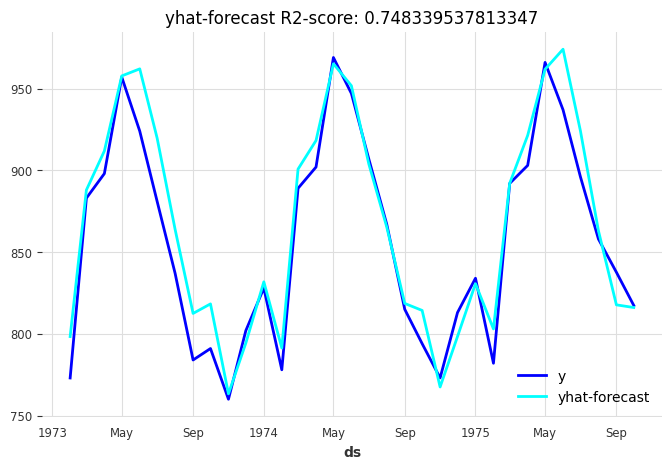

In [133]:
import matplotlib.pyplot  as plt 
plt.figure(figsize=(8, 5))
ts_test_true.plot(label="y",color='blue')
ts_test_forecast.plot(label='yhat-forecast',color='cyan')
plt.title(
    "yhat-forecast R2-score: {}".format(test_score)
)
plt.legend()

## 五，使用模型

In [ ]:
#滚动预测，使用预测的数据作为后面预测步骤的特征 
# (注意：当预测步数 n 小于等于模型的output_chunk_length，无需滚动)
ts_preds = model.predict(n = len(ts_test_scaled),series = ts_train_scaled, num_samples=1)

In [122]:
ts_test_preds  = scaler.inverse_transform(ts_preds)

In [123]:
from darts.metrics import r2_score 
test_score = r2_score(ts_test_true, ts_test_preds)

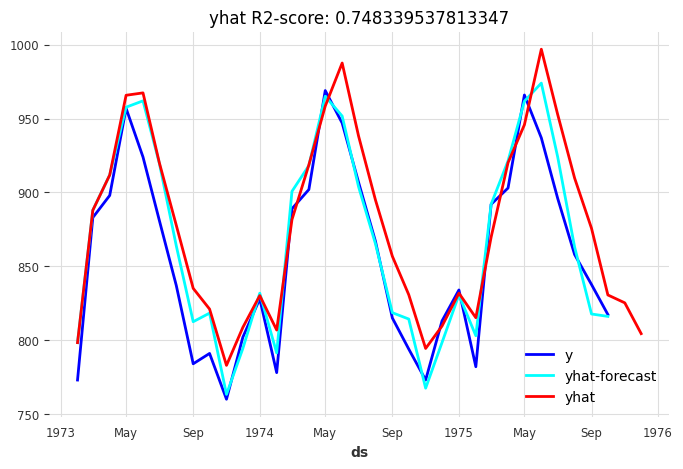

In [134]:
import matplotlib.pyplot  as plt 
plt.figure(figsize=(8, 5))
ts_test_true.plot(label="y",color='blue')
ts_test_forecast.plot(label="yhat-forecast",color='cyan')
ts_test_preds.plot(label='yhat',color='red')
plt.title(
    "yhat R2-score: {}".format(test_score)
)
plt.legend()

## 六，保存模型

In [ ]:
model.save('nbeats')
model_loaded = NBEATSModel.load('nbeats') #重新加载